Para comenzar a explorar el dataset, primero es necesario importar las librerias de manejo de bases de datos y de visualizaciones. Además se inicializa una variable guardándolo.

In [1]:
#poblar dataframe e importar librerias
import pandas as pd
import numpy as np
import datashader as ds
import plotly.express as px
import matplotlib.pyplot as plt
from datashader.mpl_ext import dsshow, alpha_colormap
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial

df = pd.read_csv('crimestats.csv')

Se revisa la estructura de la tabla para conocer el formato de los campos.

In [2]:
df.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


Se elimina los valores con coordenadas inválidas y se verifica la integridad de los datos revisando los estadísticos descriptivos, para comprobar que se haya limpiado correctamente.

In [4]:
#Limpiar registros de coordenadas corruptos
eps = 10e-6
err = -120.5
indexNames = df[abs(df['X'] - err) < eps ].index
df.drop(indexNames , inplace=True)

#Verificar integridad
df.describe()

,X,Y
count,877982.000000,877982.000000
mean,-122.422763,37.767035
std,0.025285,0.024165
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784368
max,-122.364937,37.819975


Continúa preprocesamiento de los datos. Se define campos calculados a partir del campo de fecha-hora. Se calcula también estadísticos descriptivos para las variables categóricas y numéricas.

In [5]:
#Preprocesar el campo de fecha/hora, analizar el dataset y sus estadisticos descriptivos
df['Dates'] = pd.to_datetime(df['Dates'])
df['Year'] = pd.DatetimeIndex(df['Dates']).year
df['Month'] = pd.DatetimeIndex(df['Dates']).month
df['Hour'] = pd.DatetimeIndex(df['Dates']).hour
df['Timestamp'] = (df['Dates'] - df['Dates'].min())  / np.timedelta64(1,'D')

stats_cat = df.describe(include=['datetime','object'])
stats_num = df.describe(include=['number'])
stats_mode = df.mode()

Los estadísticos descriptivos revelan que la categoría que más se repite es <strong>LARCENY/THEFT</strong>, específicamente robo a autos parqueados. El día con mayor número de crímenes registrados es viernes y la dirección con más crímenes es <strong>800 block of BRYANT ST</strong>

In [6]:
stats_cat

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,877982,877982,877982,877982,877982,877982,877982
unique,389229,39,879,7,10,17,23191
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174885,60013,133723,157174,526757,26533
first,2003-01-06 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-05-13 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN


La moda de los datos revela también que el año con más crímenes registrado es el 2013, el més con mayor actividad es octubre y la hora más peligrosa son las 12 del mediodía.

In [7]:
stats_mode

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Hour,Timestamp
0,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2013,10,18,2917.0


Es útil dibujar un gráfico de pareto para observar cuáles son las categorías más importantes a abordar para reducir el crimen en la ciudad. Se observa que cerca de 10 categorías agrupan el 80% de todos los crímenes.

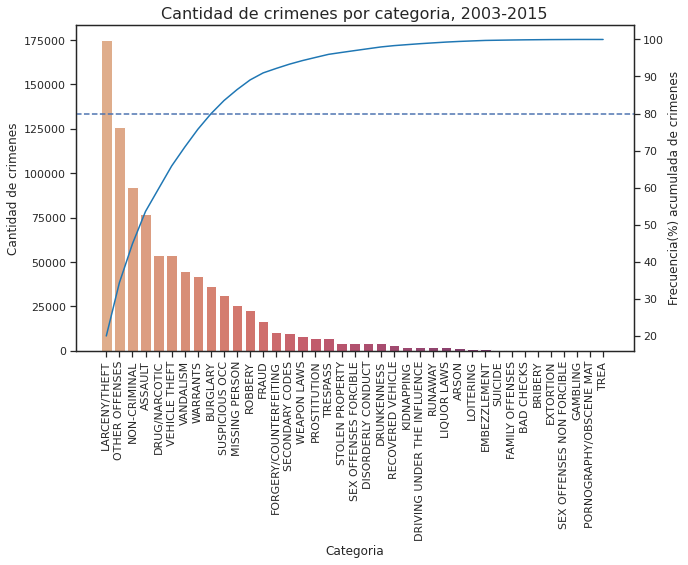

In [8]:
#dibujar pareto de categorias para identificar las mas significativas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

cat_count = pd.DataFrame(df.Category.value_counts())
cat_count['cumpercentage'] = cat_count['Category'].cumsum()/cat_count['Category'].sum()*100

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Cantidad de crimenes por categoria, 2003-2015', fontsize=16)
ax1.set_xlabel('Categoria', fontsize=12)
ax2 = sns.barplot(x=cat_count.index, y=cat_count.Category, data = cat_count, palette='flare')
ax1.set_ylabel('Cantidad de crimenes' , fontsize = 12)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2 = sns.lineplot(x=cat_count.index, y=cat_count.cumpercentage, data = cat_count, sort=False, color=color)
ax2.set_ylabel('Frecuencia(%) acumulada de crimenes', fontsize = 12)
ax2.axhline(80, ls='--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

Al graficar las líneas de tiempo, se observa picos significativos en 2013, el mes de octubre y las horas píco de tránsito: 12pm y 6 pm.

<AxesSubplot:xlabel='Year', ylabel='Category'>

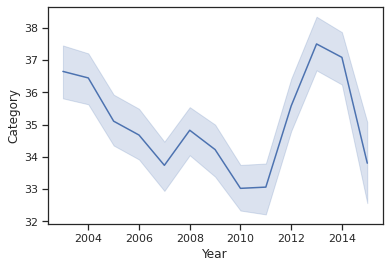

In [9]:
arr = pd.pivot_table(df,index=['Year', 'Month', 'DayOfWeek', 'Hour'],values=['Category'],aggfunc=len)
sns.lineplot(x="Year", y="Category", data=arr)

<AxesSubplot:xlabel='Month', ylabel='Category'>

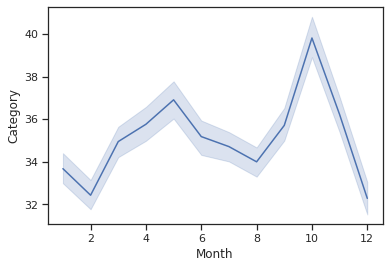

In [8]:
sns.lineplot(x="Month", y="Category", data=arr)

<AxesSubplot:xlabel='Hour', ylabel='Category'>

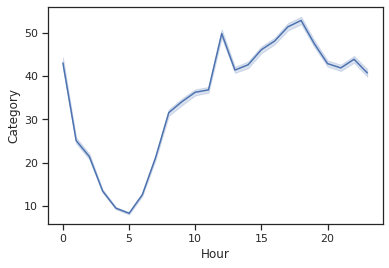

In [10]:
sns.lineplot(x="Hour", y="Category", data=arr)

Se extrae las categorias que agrupan el 80% de los datos, para tener una visualización más limpia y se trabaja únicamente con el campo de categoría y ubicación

In [10]:
top80 = cat_count.index[:12]
df_top80 = df[df.Category.isin(top80)]
df_top80["Category"] = df_top80["Category"].astype("category")
df_reduced = df_top80[['Category', 'X', 'Y']]
df_reduced.shape

(782049, 3)

Se trabaja además con la librería de datashader para representar la ubicación de los crímenes para identificar las zonas más peligrosas.

In [11]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(df, x='X', y='Y')

coords_lat, coords_lon = agg.coords['Y'].values, agg.coords['X'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [26]:
from matplotlib.cm import hot, autumn, viridis
img = tf.shade(tf.spread(agg), cmap=autumn, alpha = 255,how='eq_hist')[::-1].to_pil()


Se observa un foco importante de actividad en el noreste de la ciudad, representado por una mayor intensidad de color en el mapa.


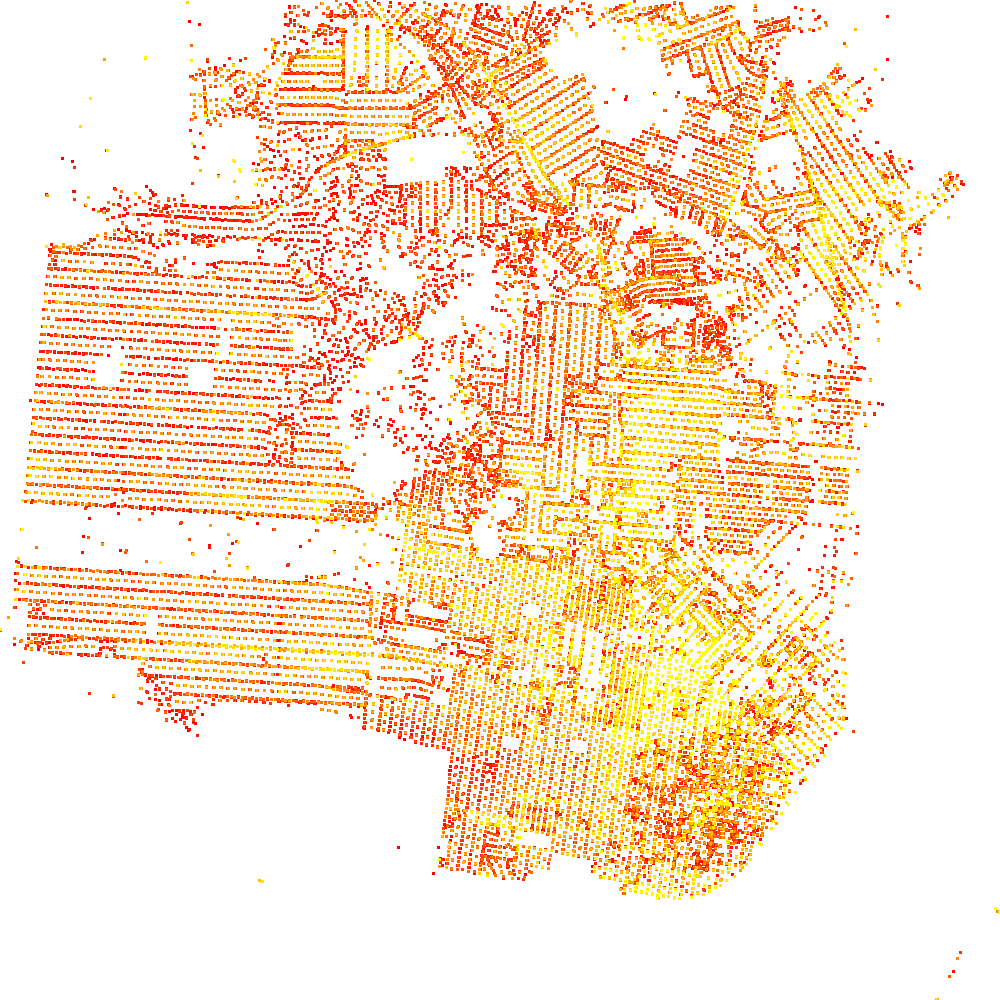

In [16]:
fig = px.scatter_mapbox(df.head(1), lat='Y', lon='X', zoom=11.8,width=1000, height=1000)

fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

Se clasifica los puntos según Categoría y se observa clusters definidos para una de ellas en zonas específicas, especialmente para las categorías de Asaltos, Robo vehicular y Drogas.

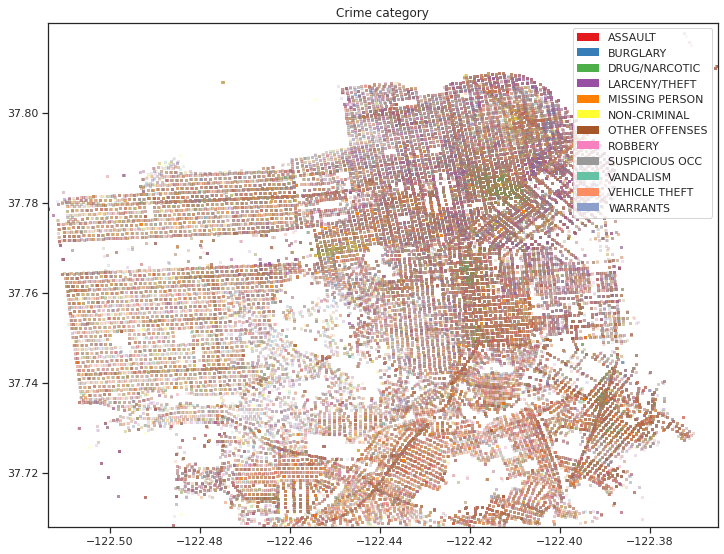

In [17]:
plt.figure(figsize=(12, 14))
ax = plt.subplot(111)

artist4 = dsshow(
    df_reduced, 
    ds.Point('X', 'Y'), 
    ds.count_cat('Category'),
    shade_hook=partial(tf.dynspread, threshold=0.131266, how='over'),
    ax=ax
)
plt.legend(handles=artist4.get_legend_elements());
plt.title('Crime category');

Se aisla únicamente la categoría de **DRUGS/NARCOTIC** para observar zonas que son claros clusters de tráfico de drogas


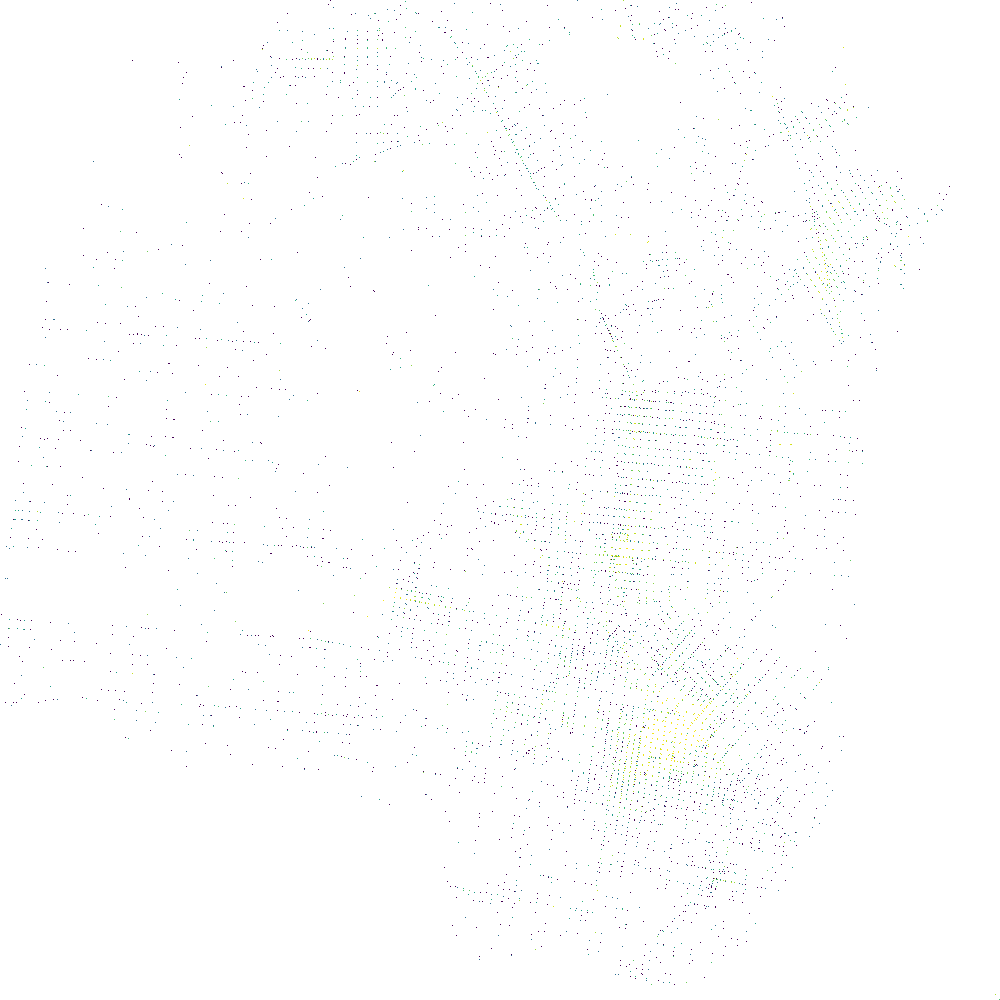

In [43]:
#dsshow(df_reduced.query('Category == "DRUG/NARCOTIC"'), ds.Point('X', 'Y'), norm='eq_hist', cmap="inferno_r");
agg_drugs = cvs.points(df_reduced.query('Category == "DRUG/NARCOTIC"'), x='X', y='Y')
img_drugs = tf.shade(tf.spread(agg_drugs), cmap=viridis, alpha = 255,how='eq_hist')[::-1].to_pil()

coords_lat_d, coords_lon_d = agg_drugs.coords['Y'].values, agg_drugs.coords['X'].values
# Corners of the image, which need to be passed to mapbox
coordinates_drugs = [[coords_lon_d[0], coords_lat_d[0]],
                    [coords_lon_d[-1], coords_lat_d[0]],
                    [coords_lon_d[-1], coords_lat_d[-1]],
                    [coords_lon_d[0], coords_lat_d[-1]]]

fig = px.scatter_mapbox(df.head(1), lat='Y', lon='X', zoom=11.8,width=1000, height=1000)

fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img_drugs,
                    "coordinates": coordinates_drugs
                }]
)
fig.show()

Finalmente, se entrena un modelo de aprendizaje supervizado, usando el algoritmo de clasificación KNN para definir un modelo predictivo explicando la variable **Category** basado en el resto de variables independientes. Primero se limpia la base de datos, eliminando los campos dependientes como **Descript** (que viene dado por la categoría) y **Address** (Que viene dado por las coordenadas)

In [17]:
df_cat = df.select_dtypes(object)
df_num = df.select_dtypes(np.number)

df_cat.drop(['Descript','Address'], axis=1, inplace=True)
df_cat.head()

,Category,DayOfWeek,PdDistrict,Resolution
0,WARRANTS,Wednesday,NORTHERN,"ARREST, BOOKED"
1,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED"
2,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED"
3,LARCENY/THEFT,Wednesday,NORTHERN,NONE
4,LARCENY/THEFT,Wednesday,PARK,NONE


Se codifica las variables categóricas para poder usarlas en el algoritmo de clasificación.

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)


Luego se une las variables numéricas con la nueva variable codificada para crear una tabla completa

In [ ]:
df_final = pd.concat([df_cat,df_num],axis=1)

Se separa el dataset, extrayendo un 20% para usarlo como set de prueba

In [ ]:
X = df_final.drop(['Category'], axis=1)
Y = df_final['Category']
X_train = np.array(X[0:int(0.80*len(X))])
Y_train = np.array(Y[0:int(0.80*len(Y))])
X_test = np.array(X[int(0.80*len(X)):])
Y_test = np.array(Y[int(0.80*len(Y)):])

Se entrena el modelo y se obtiene su puntaje de accuracy

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

KNN = KNeighborsClassifier()
KNN_fit = KNN.fit(X_train, Y_train)
KNN_pred = KNN_fit.predict(X_test)
print("KNN is %f percent accurate" % (accuracy_score(KNN_pred, Y_test)*100))